# Extract image pathces of target from Database query

This notebook extracts an image patch around the target area. It is based on the query images notebook and uses that as a base for locating the target information.

For this notebook to work, it requires a working ArangoDB. See http://localhost:8888/lab/tree/1_import_bagfiles.ipynb for how to set that up.

It is divided into multiple parts. The first is for looking at the query and allows for tuning in order to get the correct image patch. The later part will go through the bag files individually and extract the target from the images and then sort them according to bagfile origin.

## Set Up

In [1]:
import numpy as np
import quaternion
import cv2
import os
import random
import shutil

import scripts.query_image_of_bag as query_of_bag
import scripts.query_image as query_all

# Parameters
ros_topic_pose = "/gnc/ekf".replace("/", "_")[1:]
ros_topic_image = "/hw/cam_sci/info".replace("/", "_")[1:]

Specify the targets location and size:

In [2]:
# Target Pose
target_position = np.array([-0.84, 0.6, -0.81])
target_attitude = quaternion.from_euler_angles(0, 0, np.radians(180))  # order is roll, pitch, yaw

# Query Contraints
max_distance = 1.0
min_distance = 0.2
max_angle = 30

# Target size, the target is pointed to in the x-axis
target_size_y = 0.05
target_size_z = 0.07

Define the image data folder and where you would like the program to save the extracted image patches. The program will group the images by bagfile in the specified directory. They will have a the same name as the source image with patch added to the front:

In [3]:
# Define the paths for the directory with the image data and where the patches should be saved
image_path = 'PATH_TO_SCI_CAM_IMAGES' # Enter the path to the sci cam images, usually in the "isaac_sci_cam_image_delayed" folder
save_path = 'PATH_TO_WHERE_TO_SVAE_THE_IMAGES'

bag_directory_path = 'data/bags/' # Specify the path to your bagfiles

# Define the paths for the training and testing directories
train_dir = 'PATH_TO_WHERE_TO_SAVE_TRAINING_DATASET'
test_dir = 'PATH_TO_WHERE_TO_SAVE_TEST_DATASET'


# Print image and directory information?
print_info = False

## Preview the query

Query the whole database for images that contain the target

In [4]:
result_all = query_all.query_image(target_position, target_attitude, ros_topic_pose, ros_topic_image, max_distance, min_distance, max_angle, target_size_y, target_size_z)

Connected to isaac database
From database got 490 matches
From first filtering got 215 matches
Query successful, got 215 matches


Plot a few of the obtained images with the target highlighted

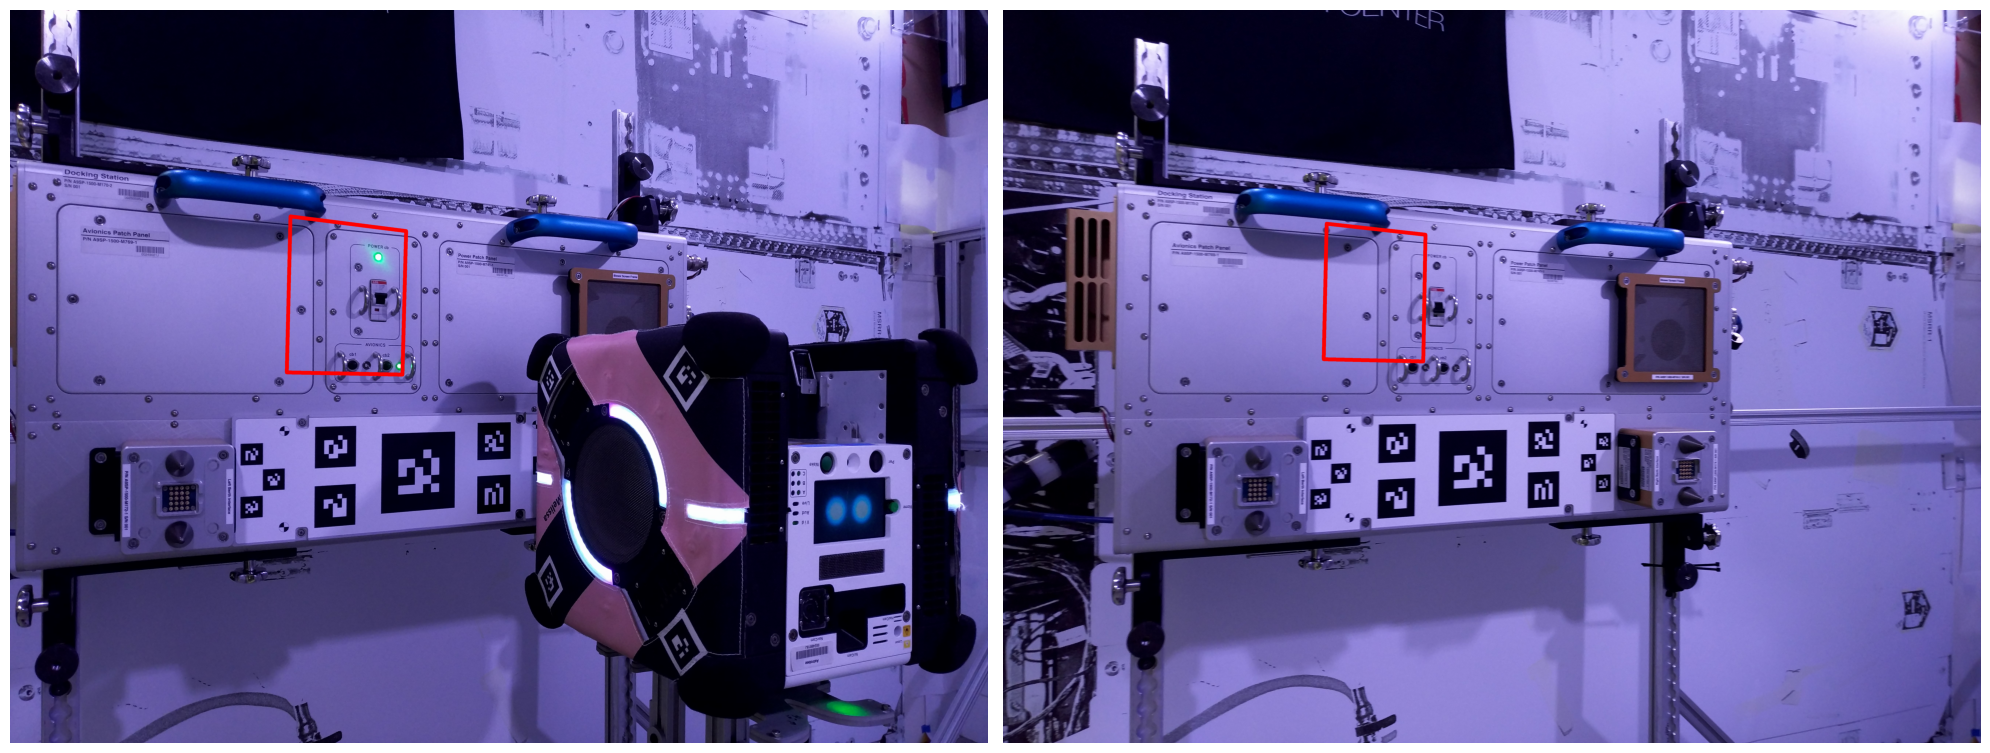

In [5]:
from scripts.plot_query_result import *

max_images = 2
num_columns = 2
fig_size = 20
plot_query_result(result_all, max_images, num_columns, fig_size)


## Extract the image patch around the target area

The extract_images function takes the wanted image and the corners of the patch/taget in the image. It extracts the target and corrects for the perspecitve.

In [6]:
def extract_image(image, corners): # Takes the image and the corners in a numpy array as input and returns the image with corrected perspective.
     # Define the perfect square corners
    perfect_square = np.array([[0, 0], [0, 500], [500, 500], [500, 0]], dtype=np.float32)

    # Convert the corner points to numpy array
    corners = np.array(corners, dtype=np.float32)

    # Calculate the perspective transformation matrix
    transform_matix = cv2.getPerspectiveTransform(corners, perfect_square)

    # Apply the perspective transformation to the image
    corrected_image = cv2.warpPerspective(image, transform_matix, (700, 500))  # Adjust the size as needed

    corrected_image = np.transpose(corrected_image, (1,0,2)) # Flips the image into portrait mode

    return corrected_image

The save_images function takes the result from the query of the database, the designated save_path and the bagfile name. It then calls the extract_image function to get the image patches.
Once the patches are extracted the program checks if there is a directory, if not it creates one.
The patches are then saved to the directory.

In [7]:
def save_images(result, save_path, bag, total_images_saved):
    amount_images = 0 # Variable for counting the amount of images that have been saved from this bag.
    for idx, element in enumerate(result): # Go though the result one by one
        image = cv2.imread(image_path + element['img']) #Load the image file with openCV
    
        corners = [element['coord_c3'],element['coord_c2'],element['coord_c1'],element['coord_c4']] # From result we extract the four corners of the target
        # Note: The corners are as follows; C1: bottom right, C2: top right, C3: top left, C4: bottom left

        extracted_image = extract_image(image, corners) # Extract the image patches from the image
        
        save_directory = (save_path + bag + '.patches' '/') # Use the specified save_path for where to save the file. Add the bag of origin and also specify that it contains patches and not the bag iself
        if not os.path.exists(save_directory): # If the directory does not exist, creake it
            os.makedirs(save_directory)
            print('Made directory ' + save_directory) # Inform the user that the dirctory has been made

        # If the user requested that the image data is printed, print it
        if print_info == True: print('--Extracted patch from image'+ element['img'] + '" in directory (' + image_path + ') and saved it as ' + 'patch_' + element['img'] + ' in directory (' + save_directory + ')') 
        
        amount_images += 1 # Itterate the counter that counts the amount of images saved.

        cv2.imwrite(save_directory + 'patch_' + element['img'], extracted_image) # Save the image to the save directory, naming it its original name with patch addad as a prefix

    # Printing information about the operation done
    print('Saved ' + str(amount_images) + ' images')
    print('Done extracting and saving image patches from bag\n')
    total_images_saved += amount_images
    return(total_images_saved)

In [ ]:
bags = os.listdir(bag_directory_path) # Load a list of all the bags in the bag directory
total_images_saved = 0 # Initialize the counter for the amount of total images saved
for bag in bags: # Go though the bags one by one
    bag_path = os.path.join(bag_directory_path, bag) # The path to that specific bag file

    if os.path.isfile(bag_path) and bag_path.endswith('.bag'): # Confim that it is a bag file
        print('Extracting from bag ' + bag) # Inform user of extraction process
        
        # Query the data base for images with the target in the bagfile
        result = query_of_bag.query_image(target_position, target_attitude, ros_topic_pose, ros_topic_image, max_distance, min_distance, max_angle, target_size_y, target_size_z, bag) 
        
        if result is not None: # Check if the query found any images or if the result is empty
            total_images_saved = save_images(result, save_path, bag, total_images_saved) # If the query was sucessful, save the images
        else:
            print('No images found\n') # Otherwise inform the user that no images was found

# Print information about amount of pictures saved and that the process is complete
print('Saved a total of ' + str(total_images_saved) + ' images')
print('Image patch extraction complete')

## Divide image patches into training and testing data
This section goes through the folders with the extracted patches and divides them into train and test data for use in the building of the CNN model.

In [ ]:
# Remove if old training/testing data exists
if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir) 

In [ ]:
# Create directories for training and testing data if they don't exist
os.makedirs(train_dir + 'on', exist_ok=True)
os.makedirs(test_dir + 'on', exist_ok=True)
os.makedirs(train_dir + 'off', exist_ok=True)
os.makedirs(test_dir + 'off', exist_ok=True)

We need to define which case each bag corresponds to. This currently has to be done by hand.

In [ ]:
# Define a dictionary mapping folder names to class labels
bag_case = {
    '20240321_2241_survey_bsharp1_0.fix_all.bag.patches': 'on',
    '20240321_2243_survey_bsharp2_0.fix_all.bag.patches': 'on',
    '20240321_2245_survey_bsharp3_0.fix_all.bag.patches': 'off',
    '20240321_2248_survey_bsharp3_0.fix_all.bag.patches': 'off',
    '20240321_2250_survey_bsharp5_0.fix_all.bag.patches': 'on',
    '20240321_2252_survey_bsharp6_0.fix_all.bag.patches': 'on',
    #'20240321_2254_survey_bsharp7_.merged.bag.patches': 'on',
    '20240321_2254_survey_bsharp7_0.fix_all.bag.patches': 'on',
    '20240321_2254_survey_bsharp7_1.fix_all.bag.patches': 'on'
}

In [ ]:
amount_of_training_data = 0.8 # 80% is going to be training data

for bagfile, case in bag_case.items(): # Go through the bagfile case list
    bag_patch_path = os.path.join(save_path, bagfile) # path to current bag file
    
    if not bag_patch_path.endswith('.patches'): # Must end with .patches
        continue

    images = os.listdir(bag_patch_path) # List all the image patches that are saved

    if case == 'on': # If the case for the current bag is that the switch was on, sets the training and testing paths accordingly
        train_path = os.path.join(train_dir, 'on')
        test_path = os.path.join(test_dir, 'on')
    elif case == 'off': # Same as for the on case but in the case the switch was set to off for the bag
        train_path = os.path.join(train_dir, 'off')
        test_path = os.path.join(test_dir, 'off')
    else: # Incase the bag has not been specified it prints that for the user and continues with the next one
        print('Case for ' + bagfile + ' is not specified as on or off')
        continue

    # Goes through all of the pictues and moves them to the approriate path, the data is split up into testing and training data in accordance with the specified split
    for idx, image_name in enumerate(images):
        image_data = cv2.imread(os.path.join(bag_patch_path, image_name))
        if not image_name.endswith('.jpg') is True: # Added to avoid error related to jupyternotebook checkpoint file
            continue
        if random.uniform(0,1) > amount_of_training_data: # Check if the image should be in the training or test data set
            cv2.imwrite(os.path.join(test_path, image_name), image_data)
        else:
            cv2.imwrite(os.path.join(train_path, image_name), image_data)
            
        

In [ ]:
# This secion checks how much data is in the training and testing data set and informs the user

print('Data copying and organization completed.\n')

trainnr = len(os.listdir(os.path.join(train_dir, 'on')))
trainnr += len(os.listdir(os.path.join(train_dir, 'off')))
testnr = len(os.listdir(os.path.join(test_dir, 'on')))
testnr += len(os.listdir(os.path.join(test_dir, 'off')))
totnr = trainnr + testnr

print('Amount of total data is: ' + str(totnr))
print('Amount of training data is: ' + str(trainnr)) #str(len(os.listdir(train_dir))))
print('Amount of test data is: ' + str(testnr)) #str(len(os.listdir(test_dir))))